Satellite images are returned by Python AWIPS as grids, and can be rendered with Cartopy pcolormesh the same as gridded forecast models in other python-awips examples. 

### Available Sources, Creating Entities, Sectors, and Products

In [1]:
from awips.dataaccess import DataAccessLayer
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import datetime

# Create an EDEX data request
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("satellite")

# get optional identifiers for satellite datatype
identifiers = set(DataAccessLayer.getOptionalIdentifiers(request))

print("Available Identifiers:")
for id in identifiers:
    if id.lower() == 'datauri':
        continue
    print(" - " + id.decode('UTF-8'))

Available Identifiers:
 - source
 - physicalElement
 - sectorID
 - creatingEntity


In [2]:
# Show available sources
identifier = "source"
sources = DataAccessLayer.getIdentifierValues(request, identifier)
print(identifier + ":")
print(list(sources))

source:
['NESDIS', 'WCDAS', 'NSOF', 'UCAR', 'McIDAS']


In [3]:
# Show available creatingEntities
identifier = "creatingEntity"
creatingEntities = DataAccessLayer.getIdentifierValues(request, identifier)
print(identifier + ":")
print(list(creatingEntities))

creatingEntity:
['GOES-16', 'Composite', 'GOES-15(P)', 'POES-NPOESS', 'UNIWISC', 'GOES-11(L)', 'Miscellaneous', 'GOES-17', 'NEXRCOMP']


In [4]:
# Show available sectorIDs
identifier = "sectorID"
sectorIDs = DataAccessLayer.getIdentifierValues(request, identifier)
print(identifier + ":")
print(list(sectorIDs))

sectorID:
['EMESO-2', 'Northern Hemisphere Composite', 'EFD', 'TCONUS', 'Hawaii Regional', 'Arctic', 'TFD', 'GOES-Sounder', 'PRREGI', 'EMESO-1', 'NEXRCOMP', 'ECONUS', 'Hawaii National', 'GOES-West', 'Antarctic', 'GOES-East', 'Alaska Regional', 'Puerto Rico National', 'Supernational', 'Alaska National', 'West CONUS', 'NH Composite - Meteosat-GOES E-GOES W-GMS']


In [5]:
# Contrust a full satellite product tree
for entity in creatingEntities:
    print(entity.decode('UTF-8'))
    request = DataAccessLayer.newDataRequest("satellite")
    request.addIdentifier("creatingEntity", entity)
    availableSectors = DataAccessLayer.getAvailableLocationNames(request)
    availableSectors.sort()
    for sector in availableSectors:
        print(" - " + sector.decode('UTF-8'))
        request.setLocationNames(sector.decode('UTF-8'))
        availableProducts = DataAccessLayer.getAvailableParameters(request)
        availableProducts.sort()
        for product in availableProducts:
            print("    - " + product.decode('UTF-8'))

GOES-16
 - ECONUS
    - ACTP
    - ADP
    - AOD
    - CAPE
    - CH-01-0.47um
    - CH-02-0.64um
    - CH-03-0.87um
    - CH-04-1.38um
    - CH-05-1.61um
    - CH-06-2.25um
    - CH-07-3.90um
    - CH-08-6.19um
    - CH-09-6.95um
    - CH-10-7.34um
    - CH-11-8.50um
    - CH-12-9.61um
    - CH-13-10.35um
    - CH-14-11.20um
    - CH-15-12.30um
    - CH-16-13.30um
    - CSM
    - CTH
    - FDC Area
    - FDC Power
    - FDC Temp
    - KI
    - LI
    - LST
    - SI
    - TPW
    - TT
    - VMP-0.00hPa
    - VMP-0.02hPa
    - VMP-0.04hPa
    - VMP-0.08hPa
    - VMP-0.14hPa
    - VMP-0.22hPa
    - VMP-0.35hPa
    - VMP-0.51hPa
    - VMP-0.71hPa
    - VMP-0.98hPa
    - VMP-1.30hPa
    - VMP-1.69hPa
    - VMP-1013.95hPa
    - VMP-103.02hPa
    - VMP-1042.23hPa
    - VMP-1070.92hPa
    - VMP-11.00hPa
    - VMP-110.24hPa
    - VMP-1100.00hPa
    - VMP-117.78hPa
    - VMP-12.65hPa
    - VMP-125.65hPa
    - VMP-133.85hPa
    - VMP-14.46hPa
    - VMP-142.38hPa
    - VMP-151.27hPa
    - VMP-16.

    - Rain fall rate
 - Supernational
    - Rain fall rate
UNIWISC
 - Antarctic
    - Imager 11 micron IR
    - Imager 12 micron IR
    - Imager 3.5-4.0 micron IR (Fog)
    - Imager 6.7-6.5 micron IR (WV)
    - Imager Visible
 - Arctic
    - Imager 11 micron IR
    - Imager 12 micron IR
    - Imager 3.5-4.0 micron IR (Fog)
    - Imager 6.7-6.5 micron IR (WV)
    - Imager Visible
 - GOES-East
    - Imager 11 micron IR
    - Imager 13 micron IR
    - Imager 3.5-4.0 micron IR (Fog)
    - Imager 6.7-6.5 micron IR (WV)
    - Imager Visible
 - GOES-Sounder
    - CAPE
    - Sounder Based Derived Lifted Index (LI)
    - Sounder Based Derived Precipitable Water (PW)
    - Sounder Based Total Column Ozone
 - GOES-West
    - Imager 11 micron IR
    - Imager 13 micron IR
    - Imager 3.5-4.0 micron IR (Fog)
    - Imager 6.7-6.5 micron IR (WV)
    - Imager Visible
GOES-11(L)
 - West CONUS
    - Low cloud base imagery
Miscellaneous
 - Alaska National
    - Percent of Normal TPW
    - Sounder Based D

##  GOES 16 Mesoscale Sectors

Define our imports, and define our map properties first. 

Latest image available: 2018-09-06 18:40:25 (0m ago)
Image grid size: (500, 500)
Image grid extent: [-113.0645, -93.15873, 28.881845, 42.417145]
Latest image available: 2018-09-06 18:39:55 (1m ago)
Image grid size: (500, 500)
Image grid extent: [-54.55265, -39.13128, 18.64958, 29.786066]


<Figure size 1152x1008 with 0 Axes>

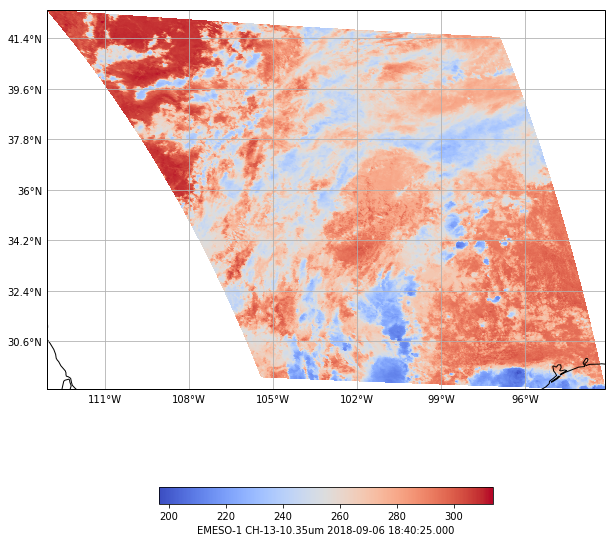

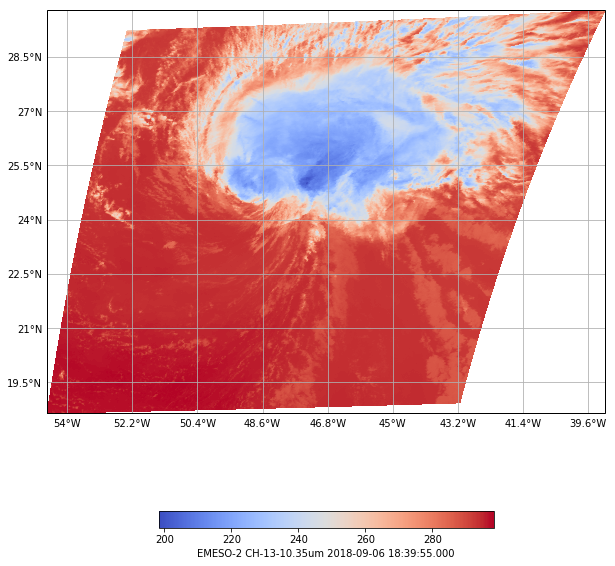

In [7]:
%matplotlib inline

def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(10,12),
            subplot_kw=dict(projection=projection))
    if bbox[0] is not np.nan:
        ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

sectors = ["EMESO-1","EMESO-2"]
fig = plt.figure(figsize=(16,7*len(sectors)))

for i, sector in enumerate(sectors):

    request = DataAccessLayer.newDataRequest()
    request.setDatatype("satellite")
    request.setLocationNames(sector)
    request.setParameters("CH-13-10.35um")

    utc = datetime.datetime.utcnow()
    times = DataAccessLayer.getAvailableTimes(request)
    hourdiff = utc - datetime.datetime.strptime(str(times[-1]),'%Y-%m-%d %H:%M:%S')
    hours,days = hourdiff.seconds/3600,hourdiff.days
    minute = str((hourdiff.seconds - (3600 * hours)) / 60)
    offsetStr = ''
    if hours > 0:
        offsetStr += str(hours) + "hr "
    offsetStr += str(minute) + "m ago"
    if days > 1:
        offsetStr = str(days) + " days ago"

    response = DataAccessLayer.getGridData(request, [times[-1]])
    grid = response[0]
    data = grid.getRawData()
    lons,lats = grid.getLatLonCoords()
    bbox = [lons.min(), lons.max(), lats.min(), lats.max()]

    print("Latest image available: "+str(times[-1]) + " ("+offsetStr+")")
    print("Image grid size: " + str(data.shape))
    print("Image grid extent: " + str(list(bbox)))

    fig, ax = make_map(bbox=bbox)
    states = cfeat.NaturalEarthFeature(category='cultural',
                                        name='admin_1_states_provinces_lines',
                                        scale='50m', facecolor='none')
    ax.add_feature(states, linestyle=':')
    cs = ax.pcolormesh(lons, lats, data, cmap='coolwarm')
    cbar = fig.colorbar(cs, shrink=0.6, orientation='horizontal')
    cbar.set_label(sector + " " \
    + grid.getParameter().decode('UTF-8') + " " \
    + str(grid.getDataTime().getRefTime()))